In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('max_colwidth', 20000000)
from sklearn import metrics
import math
import pygame

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
df1=pd.read_excel(r"G:\Localization\211015\211015.xlsx")
df2=pd.read_excel(r'G:\Localization\211016\211016.xlsx')
df3=pd.read_excel(r'G:\Localization\211017\211017.xlsx')
df4=pd.read_excel(r'G:\Localization\211023\211023.xlsx')
df5=pd.read_excel(r'G:\Localization\211024\211024.xlsx')
df6=pd.read_excel(r'G:\Localization\211026\211026.xlsx')
df7=pd.read_excel(r'G:\Localization\211027\211027.xlsx')
df8=pd.read_excel(r'G:\Localization\211028\211028.xlsx')

df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8],axis=0)
df=df.sort_values(by=['timestamp'])
df=df.drop_duplicates(subset=['timestamp'])

### The Puck ID should be chosen.

In [3]:
df=df[df['instanceId']=='0000a7c0']

In [4]:
alk=pd.DataFrame(df['timestamp'].apply(lambda x: x.replace('@','')))
df['timestamp']=pd.DataFrame(pd.to_datetime(alk['timestamp'], infer_datetime_format=True))
df['diff_seconds'] = pd.DataFrame(df['timestamp'].diff(1))['timestamp'].dt.total_seconds()

In [5]:
df=df[(df['diff_seconds']<=5)].sort_values('timestamp').reset_index().drop('index',axis=1)

In [6]:
a1=df['acceleration'].str.split(",", n = 2, expand = True).rename({0:'acc_x',1:'acc_y',2:'acc_z'},axis=1)[['acc_x','acc_y','acc_z']]
acc=pd.concat([a1,df],axis=1)

acc['acc_x']=acc['acc_x'].str.replace("[", '').str.replace("'", '').str.replace("'", '').apply(lambda x: pd.to_numeric(x, errors = 'coerce')).astype(float)
acc['acc_y']=acc['acc_y'].str.replace("'", '').str.replace("'", '').apply(lambda x: pd.to_numeric(x, errors = 'coerce')).astype(float)
acc['acc_z']=acc['acc_z'].str.replace("]", '').str.replace("'", '').apply(lambda x: pd.to_numeric(x, errors = 'coerce')).astype(float)

In [7]:
acc = acc[['timestamp','acc_x','acc_y','acc_z']]

In [8]:
"""
Three instances and their corresponding rssi values are defined.Also, a column for the Puck is added.
"""

instance_1=df['nearest'].str.slice(16,24,1)
instance_2=df['nearest'].str.slice(53,61,1)
instance_3=df['nearest'].str.slice(90,98,1)
rssi_1=df['nearest'].str.slice(33,36,1)
rssi_2=df['nearest'].str.slice(70,73,1)
rssi_3=df['nearest'].str.slice(107,110,1)
Puck=df['instanceId']

Processed_dataset=pd.DataFrame(df['timestamp'])
Processed_dataset['instance_1']=instance_1
Processed_dataset['instance_2']=instance_2
Processed_dataset['instance_3']=instance_3
Processed_dataset['rssi_1']=rssi_1
Processed_dataset['rssi_2']=rssi_2
Processed_dataset['rssi_3']=rssi_3
Processed_dataset['rssi_3']=rssi_3
Processed_dataset['Puck']=Puck


#Processed_dataset=Processed_dataset.set_index('timestamp')

In [9]:
Processed_dataset=Processed_dataset.reset_index(drop=True)

In [10]:
Processed_dataset=Processed_dataset[Processed_dataset!='']

In [11]:
Processed_dataset.dropna(inplace=True)

In [12]:
Processed_dataset=Processed_dataset.reset_index(drop=True)

In [13]:
"""
In order for the rssi columns to be ML model readable, we need to remove string records from them. Beacause rarely the dataset
coming from the Kibana has couple of string values.

The missing records should be removed.

Since by applying str.extract function, the negetaavie sign of rssi were removed, we should multiply them by -1.
"""

Processed_dataset['rssi_1']=pd.DataFrame(Processed_dataset['rssi_1'])['rssi_1'].str.extract(r'(\d+)', expand=False)
Processed_dataset['rssi_2']=pd.DataFrame(Processed_dataset['rssi_2'])['rssi_2'].str.extract(r'(\d+)', expand=False)
Processed_dataset['rssi_3']=pd.DataFrame(Processed_dataset['rssi_3'])['rssi_3'].str.extract(r'(\d+)', expand=False)

Processed_dataset.dropna(inplace=True)

Processed_dataset['rssi_1']=Processed_dataset['rssi_1'].astype(int)
Processed_dataset['rssi_2']=Processed_dataset['rssi_2'].astype(int)
Processed_dataset['rssi_3']=Processed_dataset['rssi_3'].astype(int)


In [14]:
Processed_dataset['rssi_1']=Processed_dataset['rssi_1']*-1
Processed_dataset['rssi_2']=Processed_dataset['rssi_2']*-1
Processed_dataset['rssi_3']=Processed_dataset['rssi_3']*-1

In [15]:
Processed_dataset["X1"]=Processed_dataset["instance_1"]
Processed_dataset["X2"]=Processed_dataset["instance_2"]
Processed_dataset["X3"]=Processed_dataset["instance_3"]

In [16]:
Processed_dataset.rename(columns={"instance_1":"Y1"},inplace=True)
Processed_dataset.rename(columns={"instance_2":"Y2"},inplace=True)
Processed_dataset.rename(columns={"instance_3":"Y3"},inplace=True)

In [17]:
x_axis={'0000004d':0,'00000058':4,'00000060':8,'0000004e':8,'00000061':4,'00000059':0,'000000a9':0,'000000ae':4,'000000af':8}
y_axis={'0000004d':0,'00000058':4,'00000060':0,'0000004e':4,'00000061':4,'00000059':4,'000000a9':8,'000000ae':8,'000000af':8}

In [18]:
Processed_dataset["X1"]=pd.DataFrame(Processed_dataset["Y1"].replace(x_axis))
Processed_dataset["X2"]=pd.DataFrame(Processed_dataset["Y2"].replace(x_axis))
Processed_dataset["X3"]=pd.DataFrame(Processed_dataset["Y3"].replace(x_axis))

Processed_dataset["Y1"]=pd.DataFrame(Processed_dataset["Y1"].replace(y_axis))
Processed_dataset["Y2"]=pd.DataFrame(Processed_dataset["Y2"].replace(y_axis))
Processed_dataset["Y3"]=pd.DataFrame(Processed_dataset["Y3"].replace(y_axis))

In [19]:
df=Processed_dataset

In [20]:
# Converting string values of coordiantes of the transmitters to float
df[['Y1', 'Y2', 'Y3','X1', 'X2', 'X3']]=df[['Y1', 'Y2', 'Y3','X1', 'X2', 'X3']].apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()

In [21]:
# reorder by column name
df2 = df.reindex(["timestamp","X1","Y1","X2", "Y2","X3","Y3","rssi_1","rssi_2","rssi_3","Puck"], axis=1)
df2=df2.sort_values(by=['timestamp'])

### Importing location dataset and applying Fuzzy matching

In [22]:
# Correcting the timestamp format
df1=pd.read_excel(r"G:\Localization\211015\all-location.xlsx")
df12=pd.read_excel(r"G:\Localization\211016\all-location.xlsx")
df13=pd.read_excel(r"G:\Localization\211017\all-location.xlsx")
df14=pd.read_excel(r"G:\Localization\211023\all-location.xlsx")
df15=pd.read_excel(r"G:\Localization\211024\all-location.xlsx")
df16=pd.read_excel(r"G:\Localization\211026\all-location.xlsx")
df17=pd.read_excel(r"G:\Localization\211027\all-location.xlsx")
df18=pd.read_excel(r"G:\Localization\211028\all-location.xlsx")

df1=pd.concat([df1,df12,df13,df14,df15,df16,df17,df18],axis=0)
df1=df1.sort_values(by=['timestamp'])
df1=df1.drop_duplicates(subset=['timestamp'])

# Correcting the timestamp format
alk=pd.DataFrame(df1['timestamp'].apply(lambda x: x.replace('@','')))
df1['timestamp']=pd.DataFrame(pd.to_datetime(alk['timestamp'], infer_datetime_format=True))

df1['diff_seconds'] = pd.DataFrame(df1['timestamp'].diff(1))['timestamp'].dt.total_seconds()
df1=df1[(df1['diff_seconds']<=5)].sort_values('timestamp').reset_index().drop('index',axis=1)

#Fuzzy Matching
fuzzy_matched = pd.merge_asof(df1, df2, left_on='timestamp',right_on='timestamp', direction='nearest')

#### Calculating the angle between the TARGET and First Transmitter

In [23]:
def angle_of_vector(x, y):
    return pygame.math.Vector2(x, y).angle_to((1, 0))

def angle_of_line(x):
    return angle_of_vector(x['X1']-x['location_X'], x['Y1']-x['location_Y'])
fuzzy_matched['angle_1'] = fuzzy_matched.apply(lambda x:angle_of_line(x), axis=1)

#### Correcting the angles

In [24]:
def angle_correction(x):
    if x['angle_1'] == 0:
        return x
    elif 0>x['angle_1']>=-180:
        return -1 * x['angle_1']
    elif 0<x['angle_1']<180:
        return 360 - x['angle_1']
fuzzy_matched['angle_1'] = fuzzy_matched.apply(lambda x:angle_correction(x), axis=1)

#### Calculating the angle between the TARGET and Second Transmitter

In [25]:
def angle_of_vector(x, y):
    return pygame.math.Vector2(x, y).angle_to((1, 0))

def angle_of_line(x):
    return angle_of_vector(x['X2']-x['location_X'], x['Y2']-x['location_Y'])
fuzzy_matched['angle_2'] = fuzzy_matched.apply(lambda x:angle_of_line(x), axis=1)

#### Correcting the angles

In [26]:
def angle_correction(x):
    if x['angle_2'] == 0:
        return x
    elif 0>x['angle_2']>=-180:
        return -1 * x['angle_2']
    elif 0<x['angle_2']<180:
        return 360 - x['angle_2']
fuzzy_matched['angle_2'] = fuzzy_matched.apply(lambda x:angle_correction(x), axis=1)

#### Calculating the angle between the TARGET and Third Transmitter

In [27]:
def angle_of_vector(x, y):
    return pygame.math.Vector2(x, y).angle_to((1, 0))

def angle_of_line(x):
    return angle_of_vector(x['X3']-x['location_X'], x['Y3']-x['location_Y'])
fuzzy_matched['angle_3'] = fuzzy_matched.apply(lambda x:angle_of_line(x), axis=1)

#### Correcting the angles

In [28]:
def angle_correction(x):
    if x['angle_3'] == 0:
        return x
    elif 0>x['angle_3']>=-180:
        return -1 * x['angle_3']
    elif 0<x['angle_3']<180:
        return 360 - x['angle_3']
fuzzy_matched['angle_3'] = fuzzy_matched.apply(lambda x:angle_correction(x), axis=1)

### Performing feature engineering process

In [29]:
def boundries(x):  
        
    Xmin=min(x['X1'],x['X2'],x['X3'])
    Xmax=max(x['X1'],x['X2'],x['X3'])
    Ymin=min(x['Y1'],x['Y2'],x['Y3'])
    Ymax=max(x['Y1'],x['Y2'],x['Y3'])
    
    if (Xmin<=x['location_X']<=Xmax)&(Ymin<=x['location_Y']<=Ymax):
        x['check']=1
             
    else:
             
       x['check']=0
             
    return x    
             
fuzzy_matched = fuzzy_matched.apply(lambda x:boundries(x), axis=1)

### Pre-processing the Dataset 

In [30]:
final = fuzzy_matched.drop(['diff_seconds','Puck'],axis=1)

In [31]:
def boundries(x):  
    
    x['dis1'] = np.sqrt(((x['location_X']-x['X1'])**2) + ((x['location_Y']-x['Y1'])**2))
    x['dis2'] = np.sqrt(((x['location_X']-x['X2'])**2) + ((x['location_Y']-x['Y2'])**2))
    x['dis3'] = np.sqrt(((x['location_X']-x['X3'])**2) + ((x['location_Y']-x['Y3'])**2))
    return x

        

final = final.apply(lambda x:boundries(x), axis=1)

In [32]:
def boundries(x):  
    
    x['dis1_1'] = np.sqrt(((x['X2']-x['X1'])**2) + ((x['Y2']-x['Y1'])**2))
    x['dis2_1'] = np.sqrt(((x['X3']-x['X2'])**2) + ((x['Y3']-x['Y2'])**2))
    x['dis3_1'] = np.sqrt(((x['X1']-x['X3'])**2) + ((x['Y1']-x['Y3'])**2))
    return x

        

final = final.apply(lambda x:boundries(x), axis=1)

In [33]:
# Putting labels

# Creating Orientation attribute
final['or']=np.nan

# # # #Experiment1
final.loc[('2021-10-15 08:55:45'<=final['timestamp'])&(final['timestamp']<='2021-10-15 09:11:23'),'or']='right'
final.loc[('2021-10-15 08:37:20'<=final['timestamp'])&(final['timestamp']<='2021-10-15 08:55:05'),'or']='down_right'
final.loc[('2021-10-14 17:40:00'<=final['timestamp'])&(final['timestamp']<='2021-10-14 17:54:54'),'or']='down'
final.loc[('2021-10-14 17:14:25'<=final['timestamp'])&(final['timestamp']<='2021-10-14 17:31:22'),'or']='down_left'
final.loc[('2021-10-14 16:42:04'<=final['timestamp'])&(final['timestamp']<='2021-10-14 17:00:54'),'or']='left'
final.loc[('2021-10-14 16:13:20'<=final['timestamp'])&(final['timestamp']<='2021-10-14 16:31:28'),'or']='up_left'
final.loc[('2021-10-14 15:56:25'<=final['timestamp'])&(final['timestamp']<='2021-10-14 16:11:38'),'or']='up'
final.loc[('2021-10-15 18:16:30'<=final['timestamp'])&(final['timestamp']<='2021-10-15 18:33:40'),'or']='up_right'


# # # #Experiment2
# final.loc[('2021-10-16 16:30:30'<=final['timestamp'])&(final['timestamp']<='2021-10-16 16:54:00'),'or']='right'
# final.loc[('2021-10-16 16:54:50'<=final['timestamp'])&(final['timestamp']<='2021-10-16 17:09:19'),'or']='down_right'
# final.loc[('2021-10-16 15:41:20'<=final['timestamp'])&(final['timestamp']<='2021-10-16 16:02:40'),'or']='down'
# final.loc[('2021-10-16 17:10:15'<=final['timestamp'])&(final['timestamp']<='2021-10-16 17:26:20'),'or']='down_left'
# final.loc[('2021-10-16 17:27:20'<=final['timestamp'])&(final['timestamp']<='2021-10-16 17:32:22'),'or']='down_left'
# final.loc[('2021-10-16 15:26:50'<=final['timestamp'])&(final['timestamp']<='2021-10-16 15:40:32'),'or']='left'
# final.loc[('2021-10-16 18:53:20'<=final['timestamp'])&(final['timestamp']<='2021-10-16 19:08:55'),'or']='up_left'
# final.loc[('2021-10-16 18:36:20'<=final['timestamp'])&(final['timestamp']<='2021-10-16 18:52:37'),'or']='up'
# final.loc[('2021-10-16 18:17:59'<=final['timestamp'])&(final['timestamp']<='2021-10-16 18:35:23'),'or']='up_right'


# # # #Experiment3
# final.loc[('2021-10-17 11:39:59'<=final['timestamp'])&(final['timestamp']<='2021-10-17 11:57:00'),'or']='right'
# final.loc[('2021-10-17 15:34:30'<=final['timestamp'])&(final['timestamp']<='2021-10-17 15:51:40'),'or']='down_right'
# final.loc[('2021-10-17 15:11:15'<=final['timestamp'])&(final['timestamp']<='2021-10-17 15:31:45'),'or']='down'
# final.loc[('2021-10-17 14:11:04'<=final['timestamp'])&(final['timestamp']<='2021-10-17 14:26:00'),'or']='down_left'
# final.loc[('2021-10-17 14:26:40'<=final['timestamp'])&(final['timestamp']<='2021-10-17 14:31:55'),'or']='down_left'
# final.loc[('2021-10-17 13:53:25'<=final['timestamp'])&(final['timestamp']<='2021-10-17 14:09:18'),'or']='left'
# final.loc[('2021-10-17 13:36:40'<=final['timestamp'])&(final['timestamp']<='2021-10-17 13:51:15'),'or']='up_left'
# final.loc[('2021-10-17 13:18:50'<=final['timestamp'])&(final['timestamp']<='2021-10-17 13:34:55'),'or']='up'
# final.loc[('2021-10-17 11:59:04'<=final['timestamp'])&(final['timestamp']<='2021-10-17 12:13:33'),'or']='up_right'

#Experiment4
final.loc[('2021-10-23 09:40:20'<=final['timestamp'])&(final['timestamp']<='2021-10-23 09:56:25'),'or']='right'
final.loc[('2021-10-23 12:37:59'<=final['timestamp'])&(final['timestamp']<='2021-10-23 12:54:15'),'or']='down_right'
final.loc[('2021-10-23 12:17:35'<=final['timestamp'])&(final['timestamp']<='2021-10-23 12:36:40'),'or']='down'
final.loc[('2021-10-23 11:52:15'<=final['timestamp'])&(final['timestamp']<='2021-10-23 12:07:05'),'or']='down_left'
final.loc[('2021-10-23 11:32:55'<=final['timestamp'])&(final['timestamp']<='2021-10-23 11:51:25'),'or']='left'
final.loc[('2021-10-23 10:49:35'<=final['timestamp'])&(final['timestamp']<='2021-10-23 11:06:25'),'or']='up_left'
final.loc[('2021-10-23 10:19:20'<=final['timestamp'])&(final['timestamp']<='2021-10-23 10:35:45'),'or']='up'
final.loc[('2021-10-23 09:57:25'<=final['timestamp'])&(final['timestamp']<='2021-10-23 10:14:45'),'or']='up_right'

# #Experiment5
#final.loc[('2021-10-24 19:23:40'<=final['timestamp'])&(final['timestamp']<='2021-10-24 19:32:55'),'or']='right'
# final.loc[('2021-10-24 20:53:45'<=final['timestamp'])&(final['timestamp']<='2021-10-24 21:03:35'),'or']='down_right'
# final.loc[('2021-10-24 20:42:50'<=final['timestamp'])&(final['timestamp']<='2021-10-24 20:52:40'),'or']='down'
# final.loc[('2021-10-24 20:29:04'<=final['timestamp'])&(final['timestamp']<='2021-10-24 20:39:05'),'or']='down_left'
# final.loc[('2021-10-24 20:16:35'<=final['timestamp'])&(final['timestamp']<='2021-10-24 20:26:00'),'or']='left'
# final.loc[('2021-10-24 20:05:30'<=final['timestamp'])&(final['timestamp']<='2021-10-24 20:15:15'),'or']='up_left'
# final.loc[('2021-10-24 19:53:45'<=final['timestamp'])&(final['timestamp']<='2021-10-24 20:04:10'),'or']='up'
# final.loc[('2021-10-24 19:34:55'<=final['timestamp'])&(final['timestamp']<='2021-10-24 19:44:35'),'or']='up_right'

#Experiment6
final.loc[('2021-10-26 08:33:04'<=final['timestamp'])&(final['timestamp']<='2021-10-26 08:49:05'),'or']='right'
final.loc[('2021-10-26 10:50:45'<=final['timestamp'])&(final['timestamp']<='2021-10-26 11:07:05'),'or']='down_right'
final.loc[('2021-10-26 10:33:25'<=final['timestamp'])&(final['timestamp']<='2021-10-26 10:48:45'),'or']='down'
final.loc[('2021-10-26 10:16:05'<=final['timestamp'])&(final['timestamp']<='2021-10-26 10:31:55'),'or']='down_left'
final.loc[('2021-10-26 09:59:30'<=final['timestamp'])&(final['timestamp']<='2021-10-26 10:15:10'),'or']='left'
final.loc[('2021-10-26 09:30:30'<=final['timestamp'])&(final['timestamp']<='2021-10-26 09:47:10'),'or']='up_left'
final.loc[('2021-10-26 09:08:03'<=final['timestamp'])&(final['timestamp']<='2021-10-26 09:23:25'),'or']='up'
final.loc[('2021-10-26 08:50:20'<=final['timestamp'])&(final['timestamp']<='2021-10-26 09:07:05'),'or']='up_right'

final.loc[('2021-10-27 18:45:45'<=final['timestamp'])&(final['timestamp']<='2021-10-27 18:56:00'),'or']='right'
final.loc[('2021-10-27 20:23:10'<=final['timestamp'])&(final['timestamp']<='2021-10-27 20:33:10'),'or']='down_right'
final.loc[('2021-10-27 20:10:45'<=final['timestamp'])&(final['timestamp']<='2021-10-27 20:22:25'),'or']='down'
final.loc[('2021-10-27 19:59:20'<=final['timestamp'])&(final['timestamp']<='2021-10-27 20:09:33'),'or']='down_left'
final.loc[('2021-10-27 19:48:25'<=final['timestamp'])&(final['timestamp']<='2021-10-27 19:58:33'),'or']='left'
final.loc[('2021-10-27 19:20:45'<=final['timestamp'])&(final['timestamp']<='2021-10-27 19:31:25'),'or']='up_left'
final.loc[('2021-10-27 19:09:35'<=final['timestamp'])&(final['timestamp']<='2021-10-27 19:19:35'),'or']='up'
final.loc[('2021-10-27 18:56:50'<=final['timestamp'])&(final['timestamp']<='2021-10-27 19:06:55'),'or']='up_right'

final.loc[('2021-10-28 10:22:50'<=final['timestamp'])&(final['timestamp']<='2021-10-28 10:28:35'),'or']='right'
final.loc[('2021-10-28 11:11:05'<=final['timestamp'])&(final['timestamp']<='2021-10-28 11:17:05'),'or']='down_right'
final.loc[('2021-10-28 11:04:05'<=final['timestamp'])&(final['timestamp']<='2021-10-28 11:10:05'),'or']='down'
final.loc[('2021-10-28 10:56:25'<=final['timestamp'])&(final['timestamp']<='2021-10-28 11:03:15'),'or']='down_left'
final.loc[('2021-10-28 10:49:50'<=final['timestamp'])&(final['timestamp']<='2021-10-28 10:55:05'),'or']='left'
final.loc[('2021-10-28 10:43:05'<=final['timestamp'])&(final['timestamp']<='2021-10-28 10:48:55'),'or']='up_left'
final.loc[('2021-10-28 10:36:15'<=final['timestamp'])&(final['timestamp']<='2021-10-28 10:42:15'),'or']='up'
final.loc[('2021-10-28 10:29:30'<=final['timestamp'])&(final['timestamp']<='2021-10-28 10:35:25'),'or']='up_right'


In [34]:
final = final.dropna()
from sklearn.utils import shuffle
final = shuffle(final)

In [35]:
left = final[final['or']=='left'].head(1917).copy()
right = final[final['or']=='right'].head(1917).copy()
up_left = final[final['or']=='up_left'].head(1917).copy()
up_right = final[final['or']=='up_right'].head(1917).copy()
down_left = final[final['or']=='down_left'].head(1917).copy()
down = final[final['or']=='down'].head(1917).copy()
up = final[final['or']=='up'].head(1917).copy()
down_right = final[final['or']=='down_right'].head(1917).copy()

In [36]:
final_dataset = pd.DataFrame()
final_dataset = final_dataset.append([left, right, up_left,up_right,down_left,down,up,down_right])


#final_dataset = final_dataset[['rssi_1', 'rssi_2', 'rssi_3', 'angle_1', 'angle_2','angle_3','or']]
final_dataset = final_dataset.rename({'or':'label'},axis=1)

In [37]:
final_dataset=final_dataset.dropna().sort_values('timestamp')

In [38]:
#final_dataset = pd.merge(final_dataset, acc, on=['timestamp'])
final_dataset = pd.merge_asof(final_dataset, acc, left_on='timestamp',right_on='timestamp', direction='nearest')

In [39]:
#### Encoding the lables

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
final_dataset['label'] = label.fit_transform(final_dataset['label'])
final_dataset

label.classes_

array(['down', 'down_left', 'down_right', 'left', 'right', 'up',
       'up_left', 'up_right'], dtype=object)

### Normalizing the training set

In [40]:

from sklearn.preprocessing import MinMaxScaler
### Standardized data 

X = final_dataset.drop(['timestamp','label','acc_x','acc_y','acc_z','location_X', 'location_Y', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3',],axis=1)
y = final_dataset['label']

scaler = MinMaxScaler()
X[['angle_1','angle_2','angle_3']] = scaler.fit_transform(X[['angle_1','angle_2','angle_3']])

scaler = StandardScaler()
X[['rssi_1', 'rssi_2', 'rssi_3','dis1','dis2','dis3','dis1_1','dis2_1','dis3_1']] = scaler.fit_transform(X[['rssi_1', 'rssi_2', 'rssi_3','dis1','dis2','dis3','dis1_1','dis2_1','dis3_1']])

# scaled_X = pd.DataFrame(data = X, columns = ['rssi_1', 'rssi_2', 'angle_1', 'angle_2'])
# scaled_X['label'] = y.values

# scaled_X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Trianing the model

Epoch 1/200
767/767 [==============================] - 4s 2ms/step - loss: 2.0346 - accuracy: 0.1700 - val_loss: 1.9800 - val_accuracy: 0.2112
Epoch 2/200
767/767 [==============================] - 1s 1ms/step - loss: 1.9678 - accuracy: 0.2105 - val_loss: 1.9265 - val_accuracy: 0.2265
Epoch 3/200
767/767 [==============================] - 1s 1ms/step - loss: 1.9226 - accuracy: 0.2405 - val_loss: 1.8861 - val_accuracy: 0.2611
Epoch 4/200
767/767 [==============================] - 1s 1ms/step - loss: 1.8801 - accuracy: 0.2582 - val_loss: 1.8417 - val_accuracy: 0.2810
Epoch 5/200
767/767 [==============================] - 1s 1ms/step - loss: 1.8439 - accuracy: 0.2745 - val_loss: 1.7973 - val_accuracy: 0.3018
Epoch 6/200
767/767 [==============================] - 1s 1ms/step - loss: 1.8122 - accuracy: 0.2863 - val_loss: 1.7698 - val_accuracy: 0.2960
Epoch 7/200
767/767 [==============================] - 1s 1ms/step - loss: 1.7784 - accuracy: 0.2974 - val_loss: 1.7288 - val_accuracy: 0.3051

Epoch 58/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5955 - accuracy: 0.3706 - val_loss: 1.5724 - val_accuracy: 0.3856
Epoch 59/200
767/767 [==============================] - 1s 983us/step - loss: 1.5915 - accuracy: 0.3644 - val_loss: 1.5678 - val_accuracy: 0.3791
Epoch 60/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5938 - accuracy: 0.3707 - val_loss: 1.5852 - val_accuracy: 0.3673
Epoch 61/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5910 - accuracy: 0.3701 - val_loss: 1.5733 - val_accuracy: 0.3804
Epoch 62/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5960 - accuracy: 0.3682 - val_loss: 1.5638 - val_accuracy: 0.3742
Epoch 63/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5915 - accuracy: 0.3666 - val_loss: 1.5862 - val_accuracy: 0.3677
Epoch 64/200
767/767 [==============================] - 1s 980us/step - loss: 1.5852 - accuracy: 0.3702 - val_loss: 1.5637 - val_accur

767/767 [==============================] - 1s 1ms/step - loss: 1.5646 - accuracy: 0.3849 - val_loss: 1.5494 - val_accuracy: 0.3774
Epoch 115/200
767/767 [==============================] - 1s 996us/step - loss: 1.5625 - accuracy: 0.3882 - val_loss: 1.5602 - val_accuracy: 0.3817
Epoch 116/200
767/767 [==============================] - 1s 999us/step - loss: 1.5677 - accuracy: 0.3846 - val_loss: 1.5378 - val_accuracy: 0.3921
Epoch 117/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5629 - accuracy: 0.3809 - val_loss: 1.5594 - val_accuracy: 0.3735
Epoch 118/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5677 - accuracy: 0.3802 - val_loss: 1.5662 - val_accuracy: 0.3755
Epoch 119/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5677 - accuracy: 0.3798 - val_loss: 1.5544 - val_accuracy: 0.3722
Epoch 120/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5652 - accuracy: 0.3828 - val_loss: 1.5601 - val_accuracy: 0.

767/767 [==============================] - 1s 1ms/step - loss: 1.5476 - accuracy: 0.3888 - val_loss: 1.5490 - val_accuracy: 0.3882
Epoch 171/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5424 - accuracy: 0.3889 - val_loss: 1.5456 - val_accuracy: 0.3862
Epoch 172/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5497 - accuracy: 0.3834 - val_loss: 1.5567 - val_accuracy: 0.3771
Epoch 173/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5537 - accuracy: 0.3854 - val_loss: 1.5400 - val_accuracy: 0.3814
Epoch 174/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5459 - accuracy: 0.3914 - val_loss: 1.5535 - val_accuracy: 0.3794
Epoch 175/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5511 - accuracy: 0.3889 - val_loss: 1.5592 - val_accuracy: 0.3722
Epoch 176/200
767/767 [==============================] - 1s 1ms/step - loss: 1.5475 - accuracy: 0.3875 - val_loss: 1.5572 - val_accuracy: 0.3827

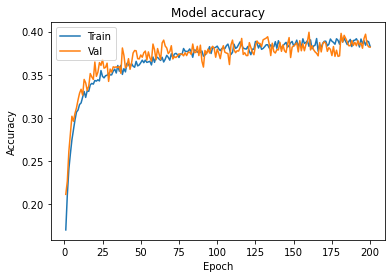

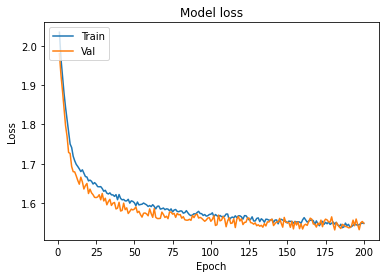

In [41]:
### Creating the Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam

model = Sequential()

# input layer
model.add(Dense(13,  activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32,  activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.1))


# output layer
model.add(Dense(8, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size=16 ,epochs = 200,validation_data= (X_test, y_test), verbose=1)

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history,200)

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report


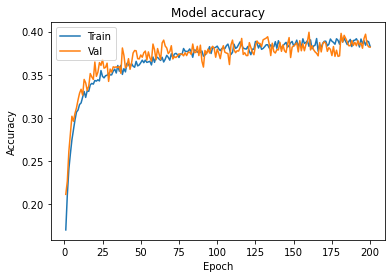

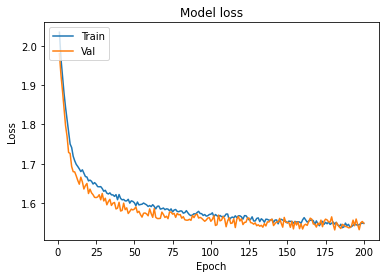

In [42]:
plot_learningCurve(history,200)

#plt.savefig('lefttt.png',dpi=650)

In [43]:
#model.save('nov_Head_Orientation_DNN.h5')

In [44]:
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred,axis=1)

In [45]:
mat = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.35      0.41      0.38       384
           1       0.36      0.54      0.43       375
           2       0.44      0.29      0.35       396
           3       0.38      0.40      0.39       371
           4       0.41      0.21      0.28       429
           5       0.41      0.39      0.40       393
           6       0.40      0.39      0.39       367
           7       0.36      0.46      0.40       353

    accuracy                           0.38      3068
   macro avg       0.39      0.39      0.38      3068
weighted avg       0.39      0.38      0.38      3068



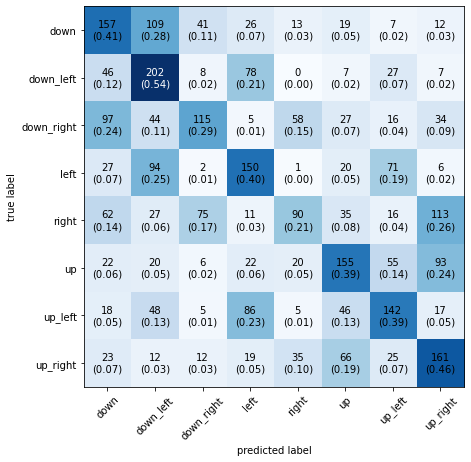

In [46]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

print(classification_report(y_test, y_pred))

### Adding confidence level to the predicted classes 

In [47]:
pred_conf = pd.DataFrame((model.predict(X_test) > 0.5).astype("int32"))

In [48]:
dictionary = {False: "low", True: "high"}
pred_conf['pred_conf'] = pd.DataFrame(pred_conf.sum(axis=1) != 0).replace({0: dictionary})

In [49]:
pred_conf = pd.DataFrame(pred_conf)

In [50]:
dic_label = {0:'down',1:'down_left',2:'down_right',3:'left',4:'right',5:'up',6:'up_left',7:'up_right'}

final_predictions = pd.DataFrame(y_pred).replace(dic_label)

In [51]:
final_predictions = pd.concat([final_predictions, pred_conf],axis=1)

In [52]:
final_predictions = final_predictions.iloc[:, [0,9]].rename({0:'orientation'},axis=1)